<a href="https://colab.research.google.com/github/IFuentesSR/RSE_drought/blob/main/ETr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference ET from ERA5 and FLDAS

In [1]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=7epKLnB-hKKuOJcifEWx8qzDBZpm3j9e9h-M-ctqV_8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g6faZrfoPL-15z5m2Td7z03_2UT8VO12_BdxVtpD--BFhq4Hzp1eOc

Successfully saved authorization token.


### Importing some libraries

In [28]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Defining some functions for calculation

In [5]:
def psy(img):
  return img.select('surface_pressure').divide(1000).multiply(0.000665)


def vapor_pressure_func(t):
  return t.expression('0.6108 * exp(17.27 * b() / (b() + 237.3))')


In [11]:
def ETr(img):
    img2 = ee.Image(ee.List(img.get('era')).get(0))

    es_tmax = vapor_pressure_func(img2.select('maximum_2m_air_temperature').subtract(273))# C

    es_tmin = vapor_pressure_func(img2.select('minimum_2m_air_temperature').subtract(273))#   C

    es_tmean = vapor_pressure_func(img2.select('mean_2m_air_temperature').subtract(273))

    es_slope = img2.select('mean_2m_air_temperature').subtract(273).expression(
        '2503 * exp(17.27 * b() / (b() + 237.3)) / (pow((b() + 237.3), 2))')

    es = es_tmin.add(es_tmax).multiply(0.5)

    ea = vapor_pressure_func(img2.select('dewpoint_2m_temperature').subtract(273))
    wind_speed = img2.select('u_component_of_wind_10m').pow(2).add(img2.select('v_component_of_wind_10m').pow(2)).sqrt()
    wind_speed = wind_speed.multiply(4.87).divide((ee.Image(10).multiply(67.8).subtract(5.42)).log())

    second = ee.Image(psy(img2)).multiply(ee.Image(900).divide(img2.select('mean_2m_air_temperature'))).multiply(wind_speed).multiply(es.subtract(ea))
    denominator = es_slope.add(ee.Image(psy(img2)).multiply(wind_speed.multiply(0.34).add(1)))

    rs = ee.Image(img).select(['SWdown_f_tavg']).multiply(0.0864)
    doy = ee.Image(30.4).multiply(ee.Date(img.get('system:time_start')).get('month')).subtract(15).round()
    delta = doy.multiply(2 * np.pi / 365).subtract(1.39435).sin().multiply(0.40928)
    omegas = lat.expression('acos(-tan(lat) * tan(delta))', {'lat':lat, 'delta':delta})
    theta = omegas.expression('omegas * sin(lat) * sin(delta) + cos(lat) * cos(delta) * sin(omegas)',
                                {'omegas':omegas, 'lat':lat, 'delta':delta})
    G = ee.Image(ee.List(img.get('temp')).get(2)).select(['mean_2m_air_temperature']).subtract(ee.Image(ee.List(img.get('temp')).get(0)).select(['mean_2m_air_temperature'])).multiply(0.07)
    dr = doy.multiply(2 * np.pi / 365).cos().multiply(0.033).add(1)
    ra = theta.expression('(24 / pi) * gsc * dr * theta', {'pi':np.pi, 'gsc':4.92, 'dr':dr, 'theta':theta});
    sin_beta_24 = lat.expression('sin(0.85 + 0.3 * lat * sin(delta) - 0.42 * pow(lat,2))',
                                {'lat':lat, 'delta':doy.multiply(2 * np.pi / 365).subtract(1.39)})
    sin_beta_24 = sin_beta_24.where(sin_beta_24.lt(0), 0)
    pa = img2.select('surface_pressure')
    w = pa.expression('0.14 * ea * pa + 2.1',
                        {'pa':pa, 'ea':ea})    

    kb = pa.expression('0.98 * exp((-0.00146 * pa) / (kt * sin_beta) - 0.075 * pow((w / sin_beta), 0.4))',
                        {'pa':pa, 'kt':1.0, 'sin_beta':sin_beta_24, 'w':w})

    kd = kb.multiply(-0.36).add(0.35).where(kb.lt(0.15), kb.multiply(0.82).add(0.18))
    rso = ra.multiply(kb.add(kd))
    fcd = rs.divide(rso).clamp(0.3,1).multiply(1.35).subtract(0.35)

    rnl = ea.expression('4.901 *pow(10,-9) * fcd * (0.34 - 0.14 * sqrt(ea)) * '+
                        '(pow(tmax_k, 4) + pow(tmin_k, 4)) / 2',
                        {'ea':ea, 'fcd':fcd, 'tmax_k':img2.select('maximum_2m_air_temperature'),
                        'tmin_k':img2.select('minimum_2m_air_temperature')})

    rn = rs.multiply(0.77).subtract(rnl)
    first = es_slope.multiply(rn.subtract(G)).multiply(0.408)
    days = ee.Date(img.get('system:time_end')).difference(img.get('system:time_start'), 'day')
    retrieve = first.add(second).divide(denominator).multiply(days)
    return retrieve.where(retrieve.lte(0), 0.01).copyProperties(img, ['system:time_start'])



## Calling and merging datasets, and applying ETr funtion to collection

In [14]:
lat = ee.Image.pixelLonLat().select('latitude').multiply(np.pi / 180)
lon = ee.Image.pixelLonLat().select('longitude').multiply(np.pi / 180)
geo = ee.Geometry.Point([27.15, 11.21])

fldas = ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001")
era5 = ee.ImageCollection("ECMWF/ERA5/MONTHLY")
 
Filta = ee.Filter.equals(leftField='system:time_start',
                          rightField='system:time_start')

saveAllJoin = ee.Join.saveAll(matchesKey='era',
                              ordering='system:time_start',
                              ascending=True)

New = saveAllJoin.apply(fldas, era5, Filta)

temp = era5.select('mean_2m_air_temperature')

diffMillis = 31* 24 * 60 * 60 * 1000

timeFilter = ee.Filter.maxDifference(difference=diffMillis,
                                     leftField='system:time_start',
                                     rightField='system:time_start')

saveAllJoin = ee.Join.saveAll(matchesKey='temp',
                              ordering='system:time_start',
                              ascending=True)

New = saveAllJoin.apply(New, era5, timeFilter)

New = New.filterDate('1970-01-01', '2020-01-01')

ETref = New.map(ETr)

### Mapping one month ETr

In [31]:
mapidCon = ee.Image(ETref.filterDate('2018-07-01', '2021-12-12').first()).resample('bicubic').getMapId({'min': 0.1, 'max': 400, 'palette': 'FF0000, FFFF00, 00FF00, 00FFFF, 0000FF'})
centroid = geo.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=2)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='ETr',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

## Testing in a single location

In [24]:
def sample_collection(geo):
    def wrap(img):
        img = ee.Image(img)
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
        etr = img.reduceRegion('first', geo, 10000).values().get(0)
        return ee.Feature(None, {'date':date, 'ETr':etr})
    return wrap


series = ETref.map(sample_collection(geo)).getInfo()


### Plotting time series of ETr

Text(0, 0.5, 'ETr')

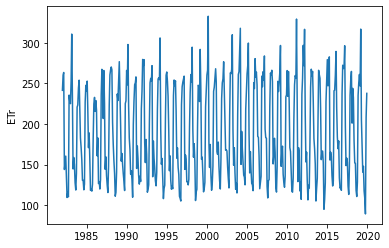

In [32]:
dates = [pd.to_datetime(n['properties']['date']) for n in series['features']]
etrs = [n['properties']['ETr'] for n in series['features']]
plt.plot(dates, etrs)
plt.ylabel('ETr')